In [1]:
import matplotlib.pyplot as plt

from desc.continuation import solve_continuation_automatic
from desc.backend import jnp, functools, jit
from desc.examples import get
import desc.io
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import Grid, _periodic_spacing, LinearGrid
from desc.equilibrium.coords import get_rtz_grid
from desc.objectives import (
    AspectRatio,
    FixBoundaryR,
    FixBoundaryZ,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
    BallooningStability,
    EffectiveRadius,
    ParallelConnectionLength,
)
from desc.optimize import Optimizer
from desc.plotting import plot_comparison, plot_section


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


DESC version 0.12.2+414.g006934812.dirty,using JAX backend, jax version=0.4.31, jaxlib version=0.4.31, dtype=float64
Using device: CPU, with 26.22 GB available memory


## Methods ##

In [8]:
# Function to get value of a parameter directly
def get_value(eq,name,grid):
    return eq.compute(name,grid=grid)[name]

# Function to get the straight field line coordinate system, need iota for jit
# @functools.partial(jit, static_argnames=["rho","alpha","n_pol","n_points"])
def get_field_line_grid(eq,iota,rho=0.5,alpha=0,n_pol = 4,n_points = 200):
    n_tor = n_pol/(iota*eq.NFP)
    good_grid = get_rtz_grid(
        eq,
        jnp.array(rho),
        # np.array(rho),
        jnp.array(alpha),
        # np.linspace(0,2*n_tor*np.pi,n_points*n_pol),
        jnp.linspace(0,2*n_tor*jnp.pi,n_points*n_pol),
        coordinates="raz",
        iota = iota,
        period=(jnp.inf,2*jnp.pi,jnp.inf),
    )
    return good_grid

In [3]:
def run_step(k, eq, grid, target_type="mean"):
    """Run a step of the precise QH optimization example from Landreman & Paul."""

    # create grid where we want to minimize QS error. Here we do it on 3 surfaces
    # grid = get_field_line_grid(eq,n_pol=10)

    # we create an ObjectiveFunction, in this case made up of multiple objectives
    # which will be combined in a least squares sense
    objective = ObjectiveFunction(
        (
            # pass in the grid we defined, and don't forget the target helicity!
            EffectiveRadius(eq=eq,grid=grid, target_type=target_type),
            # ForceBalance(eq=eq),
            # ParallelConnectionLength(eq=eq,grid=grid),
            # BallooningStability(eq=eq),
            # try to keep the aspect ratio about the same
            # AspectRatio(eq=eq, target=8, weight=100),
        ),
    )
    # as opposed to SIMSOPT and STELLOPT where variables are assumed fixed, in DESC
    # we assume variables are free. Here we decide which ones to fix, starting with
    # the major radius (R mode = [0,0,0]) and all modes with m,n > k
    R_modes = jnp.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[
                jnp.max(jnp.abs(eq.surface.R_basis.modes), 1) > k, :
            ],
        )
    )
    Z_modes = eq.surface.Z_basis.modes[
        jnp.max(jnp.abs(eq.surface.Z_basis.modes), 1) > k, :
    ]
    # next we create the constraints, using the mode number arrays just created
    # if we didn't pass those in, it would fix all the modes (like for the profiles)
    constraints = (
        ForceBalance(eq=eq),
        FixBoundaryR(eq=eq, modes=R_modes),
        FixBoundaryZ(eq=eq, modes=Z_modes),
        FixPressure(eq=eq),
        FixCurrent(eq=eq),
        FixPsi(eq=eq),
    )
    # this is the default optimizer, which re-solves the equilibrium at each step
    optimizer = Optimizer("proximal-lstq")

    eq_new, history = eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=20,  # we don't need to solve to optimality at each multigrid step
        verbose=3,
        # xtol=1e-8,
        # gtol=1e-8,
        # ftol = 1e-8,
        # ctol = 1e-8,
        copy=True,  # don't modify original, return a new optimized copy
        options={
            # Sometimes the default initial trust radius is too big, allowing the
            # optimizer to take too large a step in a bad direction. If this happens,
            # we can manually specify a smaller starting radius. Each optimizer has a
            # number of different options that can be used to tune the performance.
            # See the documentation for more info.
            "initial_trust_ratio": 1.0,
        },
    )

    return eq_new

In [4]:
def plot_Kd (eq):
    iota_grid = LinearGrid(
    rho=0.5
    )
    iota = jnp.abs(eq.compute("iota",iota_grid)["iota"][0])
    grid = get_field_line_grid(eq,iota,n_pol=10)
    Kd = get_value(eq,"Kd",grid)
    plt.figure()
    plt.plot(grid.nodes[:,2],Kd)
    plt.axhline(0,color='r',linestyle="--")
    plt.xlabel(r"$\zeta$")
    plt.ylabel(r"$K_d$")
    R_eff = get_value(eq,"R_eff",grid)
    L_par = get_value(eq,"L_par",grid)
    a = get_value(eq,"a",grid)

    # Format the text to be displayed in the box
    textstr = (
        f"Mean value of $R_{{eff}}$: {R_eff.mean():.3f}\n"
        f"Mean value of $L_{{par}}$: {L_par.mean():.3f}\n"
        f"Maximum value of $R_{{eff}}$: {R_eff.max():.3f}\n"
        f"Maximum value of $L_{{par}}$: {L_par.max():.3f}\n"
    )

    # Add the text box to the plot
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(
        0.05, 0.95, textstr, transform=plt.gca().transAxes,
        fontsize=12, verticalalignment='top', bbox=props
    )

    # Add a legend and show the plot
    # plt.legend()
    plt.show()

    # Print the values for verification
    # print(f"Values of R_eff are: {R_eff}")
    # print(f"Values of L_par are: {L_par}")


In [5]:
def compare_optimizations(eq,mode_lim=1):
    eqfam = EquilibriaFamily(eq)
    iota_grid = LinearGrid(
        rho=0.5
        )
    iota = jnp.abs(eq.compute("iota",iota_grid)["iota"][0])
    grid = get_field_line_grid(eq,iota,n_pol=10)
    eq1 = run_step(mode_lim,eq,grid,target_type="mean")
    eq2 = run_step(mode_lim,eq,grid,target_type="max")
    eqfam.append(eq1)
    eqfam.append(eq2)
    plot_Kd(eq);
    plot_Kd(eq1);
    plot_Kd(eq2);
    return eqfam


## Testing ##

In [6]:
eq = get("WISTELL-A")

In [10]:
eq_fam = compare_optimizations(eq)

/tmp/ipykernel_995021/3921199066.py:23: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 476 ms
Timer: Objective build = 677 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 154 ms
Timer: Objective build = 185 ms
Timer: Proximal projection build = 2.49 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 331 ms
Timer: Linear constraint projection build = 606 ms
Number of parameters: 8
Number of objectives: 1
Timer: Initializing the optimization = 3.53 sec

Starting optimization
Using method: proximal-fmintr


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[340]
The error occurred while tracing the function compute_scalar at /home/jjfrybes/DESC/desc/objectives/objective_funs.py:354 for jit. 
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

/tmp/ipykernel_973994/178291541.py:22: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 1.49 sec
Timer: Objective build = 2.09 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 1.28 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 872 ms
Timer: Objective build = 956 ms
Timer: Linear constraint projection build = 3.41 sec
Timer: Linear constraint projection build = 242 ms
Number of parameters: 1470
Number of objectives: 1
Number of equality constraints: 3078
Number of inequality constraints: 0
Timer: Initializing the optimization = 8.11 sec

Starting optimization
Using method: fmin-auglag-bfgs
   Iteration     Total nf

/tmp/ipykernel_973994/178291541.py:22: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 259 ms
Timer: Objective build = 346 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 226 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 53.1 ms
Timer: Objective build = 66.0 ms
Timer: Linear constraint projection build = 2.35 sec
Timer: Linear constraint projection build = 247 ms
Number of parameters: 1470
Number of objectives: 1
Number of equality constraints: 3078
Number of inequality constraints: 0
Timer: Initializing the optimization = 3.26 sec

Starting optimization
Using method: fmin-auglag-bfgs
   Iteration     Total nfev  

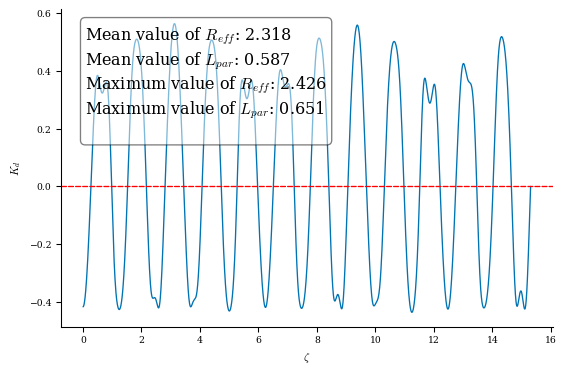

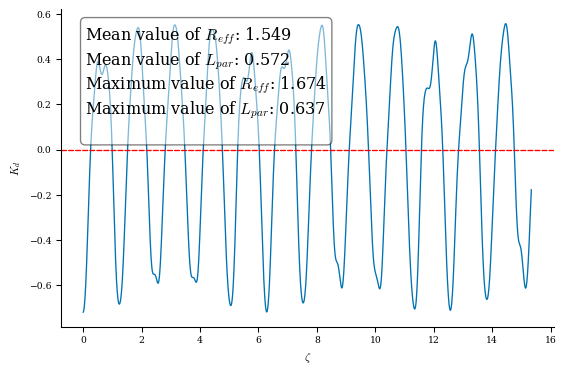

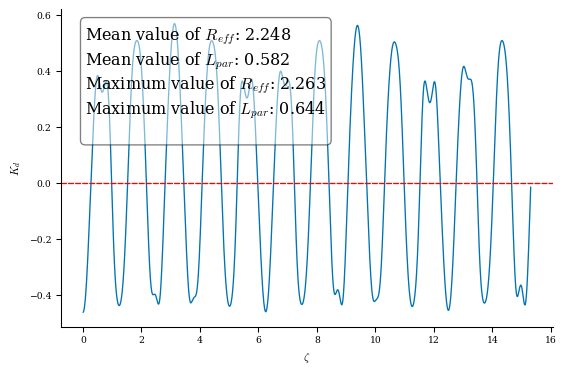

In [10]:
eqfam2 = compare_optimizations(eq,mode_lim=2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


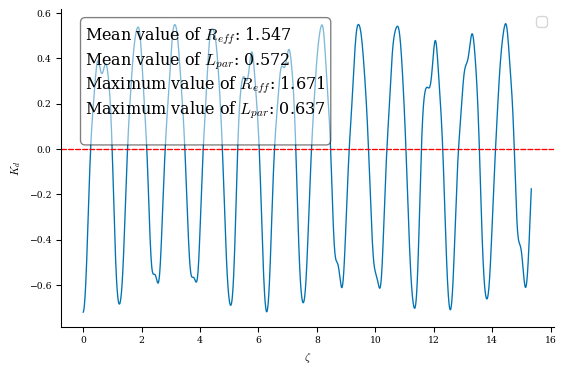

Values of R_eff are: [1.47544762 1.63507168 1.63366791 1.47108183 1.45099903 1.49406659
 1.67110407]
Values of L_par are: [0.63685962 0.62918661 0.62918661 0.53711052 0.52943751 0.52176451
 0.52176451]


In [13]:
grid = plot_Kd(eq1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


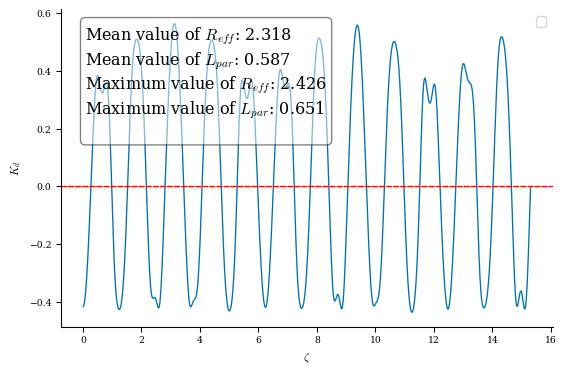

Values of R_eff are: [2.29638528 2.29951635 2.30920581 2.28600875 2.42595058 2.31557901
 2.2906309 ]
Values of L_par are: [0.65108866 0.63576892 0.62810906 0.55151039 0.55151039 0.54385052
 0.54385052]


In [5]:
iota_grid = LinearGrid(
    rho=0.5
)
iota = jnp.abs(eq.compute("iota",iota_grid)["iota"][0])
grid = get_field_line_grid(eq,iota,n_pol=10)
Kd = get_value(eq,"Kd",grid)
plt.figure()
plt.plot(grid.nodes[:,2],Kd)
plt.axhline(0,color='r',linestyle="--")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$K_d$")
R_eff = get_value(eq,"R_eff",grid)
L_par = get_value(eq,"L_par",grid)
a = get_value(eq,"a",grid)

# Format the text to be displayed in the box
textstr = (
    f"Mean value of $R_{{eff}}$: {R_eff.mean():.3f}\n"
    f"Mean value of $L_{{par}}$: {L_par.mean():.3f}\n"
    f"Maximum value of $R_{{eff}}$: {R_eff.max():.3f}\n"
    f"Maximum value of $L_{{par}}$: {L_par.max():.3f}\n"
)

# Add the text box to the plot
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(
    0.05, 0.95, textstr, transform=plt.gca().transAxes,
    fontsize=12, verticalalignment='top', bbox=props
)

# Add a legend and show the plot
plt.legend()
plt.show()

# Print the values for verification
print(f"Values of R_eff are: {R_eff}")
print(f"Values of L_par are: {L_par}")


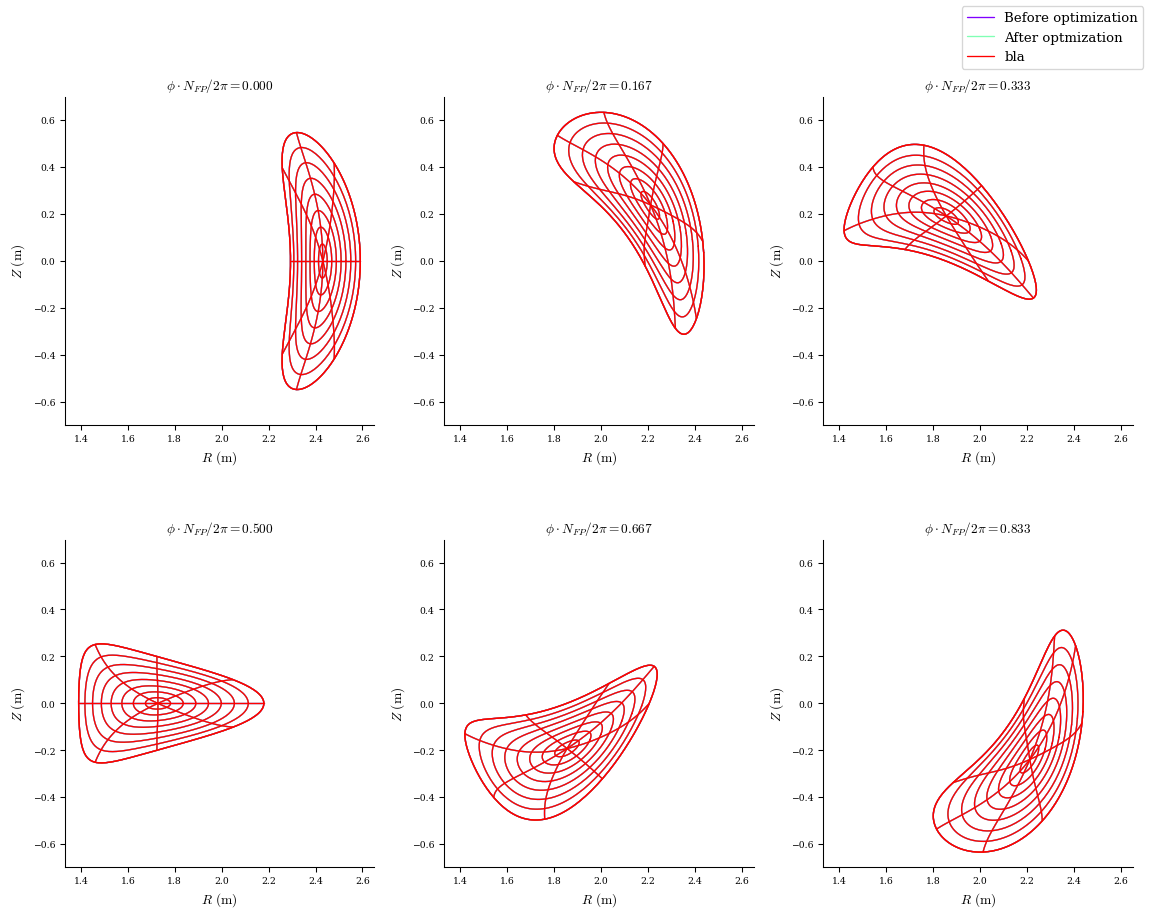

In [17]:
fig, ax = plot_comparison(
    eqs=[eqfam2[0], eqfam2[1], eqfam2[2]],
    labels=[
        "Before optimization",
        "After optmization",
        "bla",
    ],
)

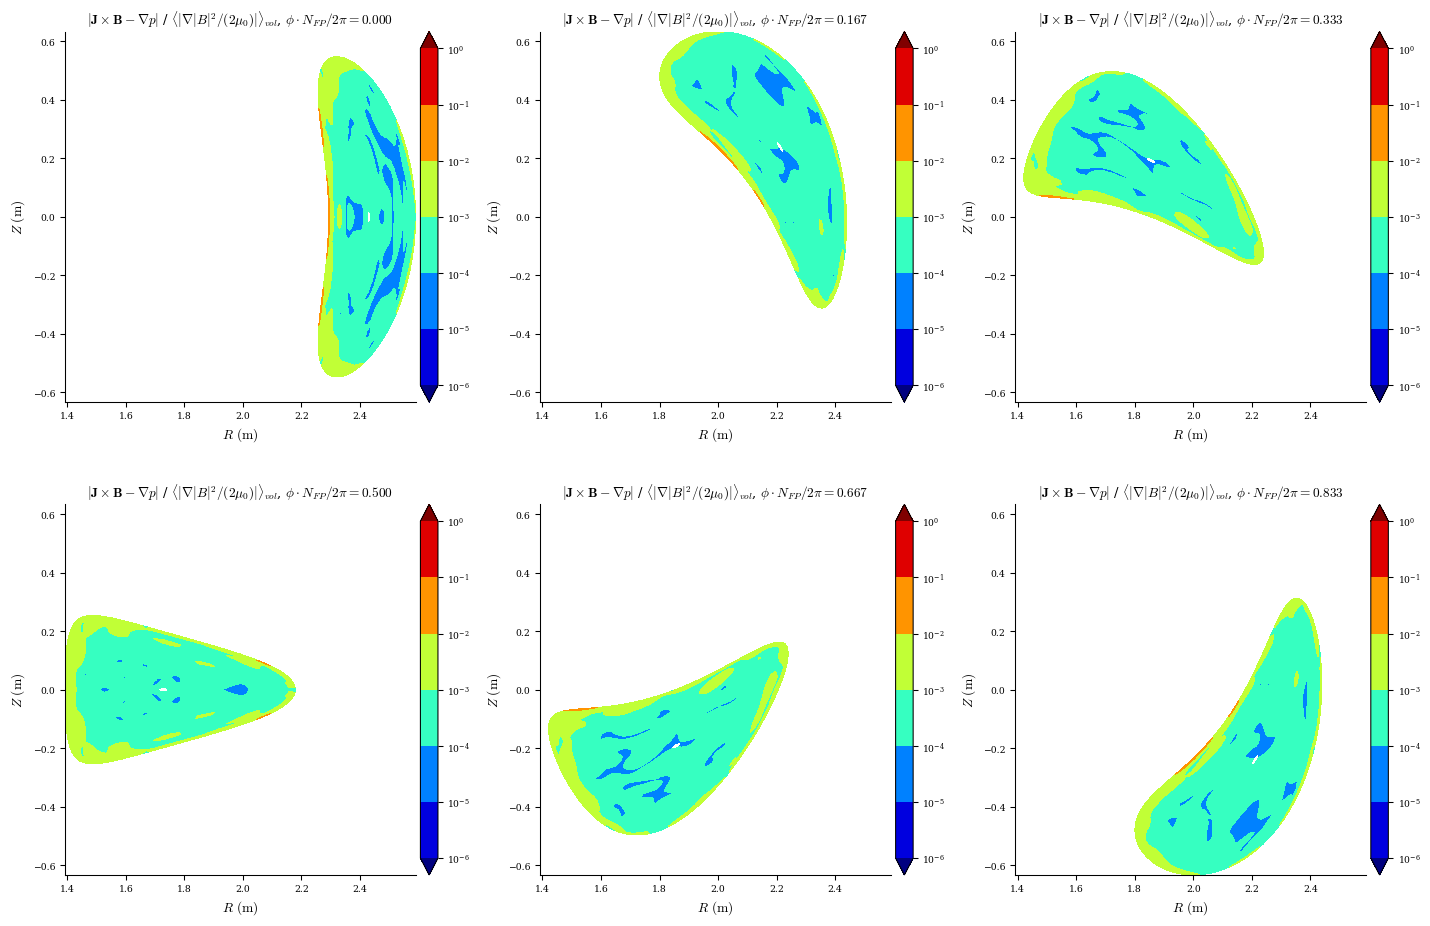

In [13]:
plot_section(eqfam2[0], "|F|", norm_F=True, log=True);

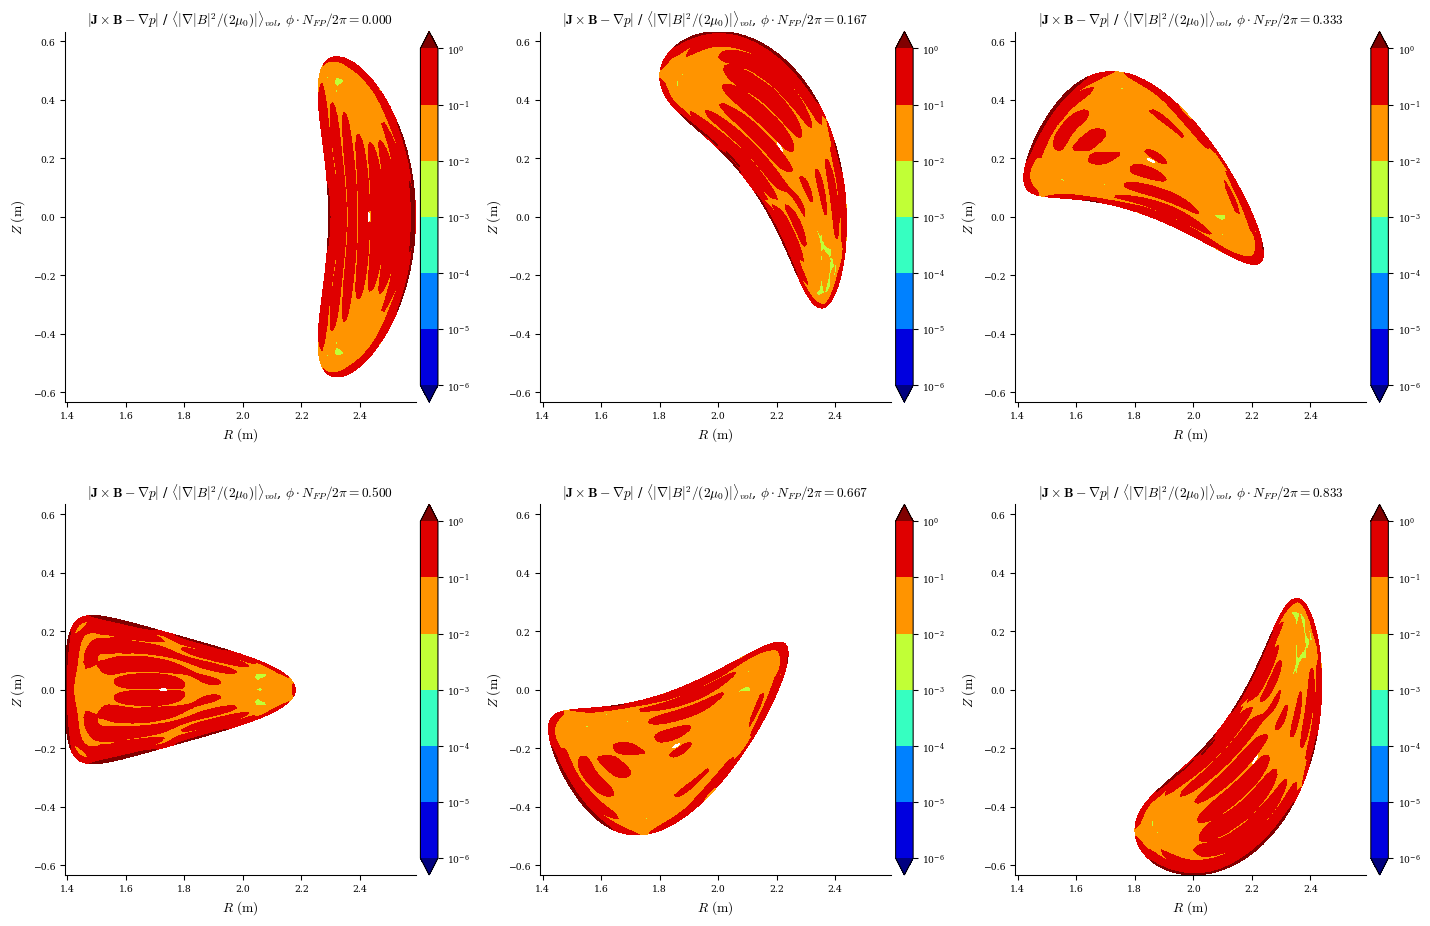

In [14]:
plot_section(eqfam2[1], "|F|", norm_F=True, log=True);

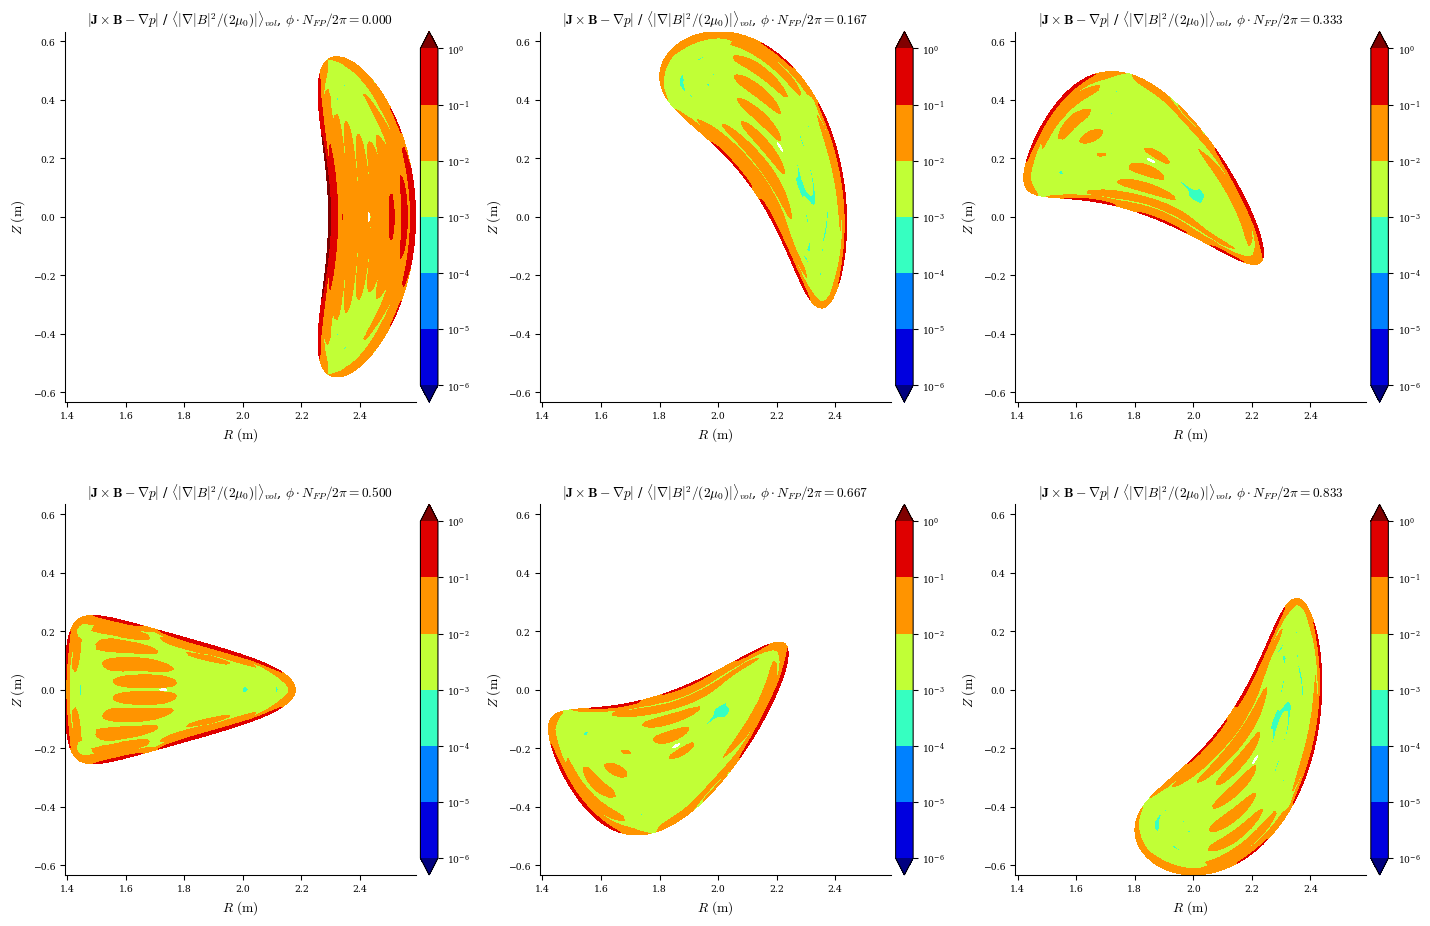

In [15]:
plot_section(eqfam2[-1], "|F|", norm_F=True, log=True);

In [19]:
iota_grid = LinearGrid(
    rho=0.5
)
iota = jnp.abs(eq.compute("iota",iota_grid)["iota"][0])
grid = get_field_line_grid(eq,iota,n_pol=10)

In [20]:
eq2 = run_step(1,eqfam2[1],grid)

/tmp/ipykernel_973994/1393643024.py:23: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 58.1 ms
Timer: Objective build = 71.3 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 338 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 59.6 ms
Timer: Objective build = 71.8 ms
Timer: Linear constraint projection build = 1.61 sec
Timer: Linear constraint projection build = 257 ms
Number of parameters: 1454
Number of objectives: 3078
Number of equality constraints: 3078
Number of inequality constraints: 0
Timer: Initializing the optimization = 2.40 sec

Starting optimization
Using method: fmin-auglag-bfgs
   Iteration     Total nfev        

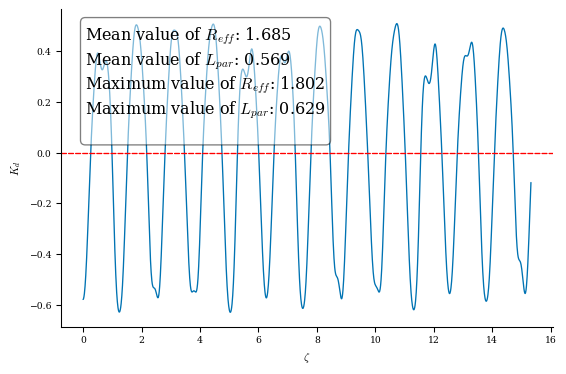

In [21]:
plot_Kd(eq2)

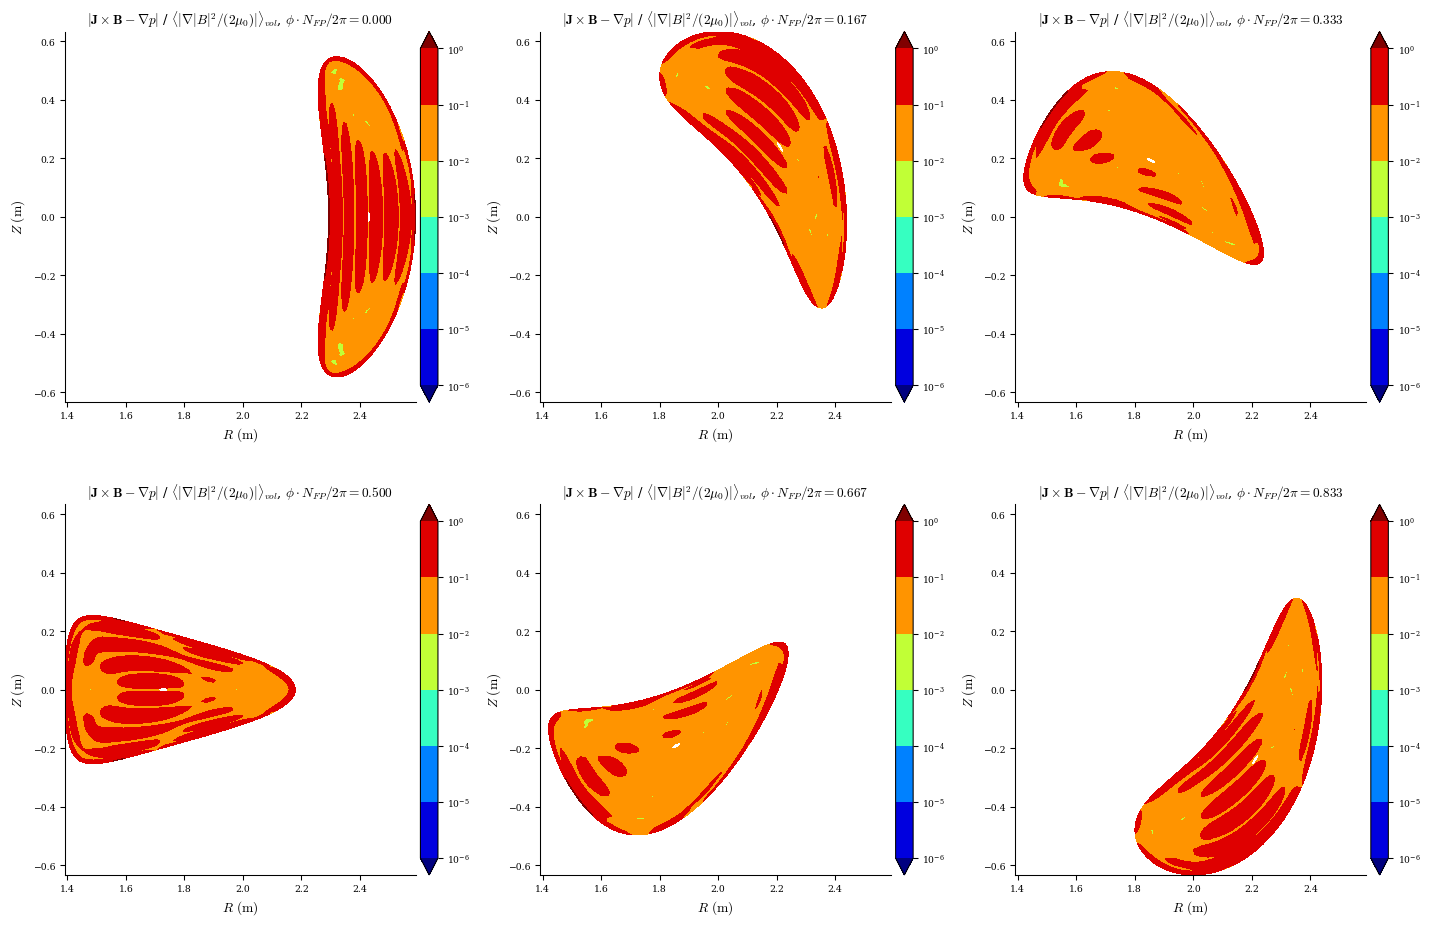

In [22]:
plot_section(eq2, "|F|", norm_F=True, log=True);